In [432]:
import torch
import random
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2 

# random.seed(0)
# np.random.seed(0)

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [433]:
def load_data(path):
    X = []
    y = []
    failed = []
    letter_arr = list(map(chr,[48, 49 ,50 ,51 ,52 ,53 ,54 ,55, 56 ,57 ,65, 
                               66 ,67, 68, 69, 70, 71, 76 ,79 ,80, 81 ,83]))
    for img_path in glob.glob(path):
        #img = np.mean(plt.imread(img_path),axis =2)
        img = plt.imread(img_path)
        img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2))
        #field = np.zeros((330,330))
        #field[:150,:]=img.copy()
        if "test" in img_path:
            img_name = list(map(lambda x: letter_arr.index(x),img_path.split(".")[0][5:].upper()))
        elif "train" in img_path:
            img_name = list(map(lambda x: letter_arr.index(x),img_path.split(".")[0][6:].upper()))
        else:
            img_name = list(map(lambda x: letter_arr.index(x),img_path.split(".")[0][9:].upper()))
            #print(img_path)
        if len(img_name)!=5:
            failed.append(img)
            print(img_path)
            continue
        
        X.append(magic(img[3:-7, 3:-7]))
        y.append(list(img_name))
        
    return np.asarray(X), np.asarray(y),failed

def magic(img):
    img = img.copy()
    img[:,:,0]+=0.01
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)*255
    img_hsv = img_hsv.astype('uint8')
    th2 = cv2.adaptiveThreshold(img_hsv[:,:,1],255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    ksize = (4, 4) 
    th2 = cv2.blur(th2, ksize) 
   # th2 = cv2.adaptiveThreshold(th2,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
   # th2 = th2.astype(int)
    return th2/255

def from_digits(list_digits):
    letter_arr = list(map(chr,[48, 49 ,50 ,51 ,52 ,53 ,54 ,55, 56 ,57 ,65, 
                               66 ,67, 68, 69, 70, 71, 76 ,79 ,80, 81 ,83]))
    chrs = list(map(lambda x:letter_arr[x], list_digits))
    return "".join(chrs)

def per_accuracy(data, answer):
    s = np.sum((data.argmax(dim=1) == answer).detach().numpy(),axis =1)
    count_of_excellent = np.where(s == 5)

    return len(count_of_excellent[0])/len(s)

def add_noise(imgs, t = 0.2):
    z, _, x, y = imgs.shape
    x_mask = np.random.randint(0,x, size = int((x*y*z)*t) )
    y_mask = np.random.randint(0,y, size = int((x*y*z)*t) )
    z_mask = np.random.randint(0,z, size = int((x*y*z)*t) )
    
    new_imgs = imgs.clone().detach()
    new_imgs[z_mask,:,x_mask,y_mask] = 0.
    
#     for i in range(0,x-3):
#         for j in range(0,y-3):
#             for k in range(0,z):
#                 new_imgs[k,:,i,j] = new_imgs[k,:,i:i+3,j:j+3].mean()
    
    return new_imgs

    

train\5A4B.png
train\D780.png
train\ec5f.png
test\27AA.png
test\9B07.png
test\B20EB0.png
test\E1AEEF.png
test\E93E.png
(559, 65, 155)


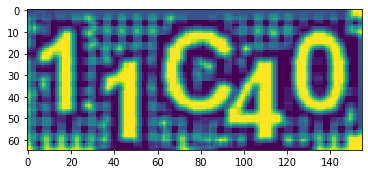

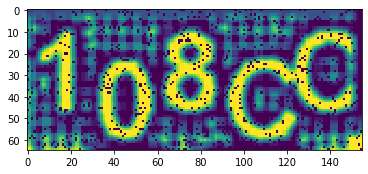

In [434]:
X_train, y_train, f = load_data("train//*")
X_test, y_test, f = load_data("test//*")

print(X_train.shape)

X_train = X_train.reshape(-1,1,X_train[0].shape[0],X_train[0].shape[1])
X_test = X_test.reshape(-1,1,X_test[0].shape[0],X_test[0].shape[1])

X_test = torch.from_numpy(X_test).float()
X_train = torch.from_numpy(X_train).float()


y_test = torch.from_numpy(y_test.astype(np.float))
y_train = torch.from_numpy(y_train.astype(np.float))


plt.imshow(X_train[2,0])
plt.show()
plt.imshow(add_noise(X_train, 0.1)[0,0])
plt.show()

In [456]:
model2

CapchaNet(
  (conv1): Conv2d(1, 5, kernel_size=(10, 10), stride=(1, 1), padding=(2, 2))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=5, stride=2, padding=0)
  (conv2): Conv2d(5, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=2520, out_features=1425, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=1425, out_features=120, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (act5): Tanh()
  (dropout3): Dropout(p=0.05, inplace=False)
  (fc4): Linear(in_features=84, out_features=22, bias=True)
)

In [463]:
class CapchaNet(torch.nn.Module):
    def __init__(self):
        super(CapchaNet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=5, kernel_size=10, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=5, stride=2)
        
        self.conv2 = torch.nn.Conv2d(
            in_channels=5, out_channels=25, kernel_size=5, padding=2)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)        
        
        self.fc1   = torch.nn.Linear(2520, 1425) #2520 1425
        self.act3  = torch.nn.Tanh()        
        
        self.fc2   = torch.nn.Linear(1425, 120)
        self.act4  = torch.nn.Tanh()   
            
        self.fc3   = torch.nn.Linear(120, 84)
        self.act5  = torch.nn.Tanh()
        
        self.dropout3 = torch.nn.Dropout(p=0.1)
       
        self.fc4   = torch.nn.Linear(84, 22)       
    
    def forward(self, x):        

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)        

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), 5, 5*14*36)
        
        x = self.fc1(x)
        x = self.act3(x)

        x = self.fc2(x)
        x = self.act4(x)
        
        x = self.fc3(x)
        x = self.act5(x)
        
        x = self.dropout3(x)
        x = self.fc4(x)  
        
        return x
model = CapchaNet()

In [464]:
x =model(X_train)
print(x.shape)
print(sum(x[0,0]))
print(x.shape)

torch.Size([559, 5, 22])
tensor(-0.4520, grad_fn=<AddBackward0>)
torch.Size([559, 5, 22])


In [451]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [452]:
test_accuracy_history = []
test_loss_history = []

for epoch in range(1000):
#     order = np.random.permutation(len(X_train))
    
    optimizer.zero_grad()

#     X_batch = X_train[:]
#     y_batch = y_train[:]
    batch = add_noise(X_train, 0.1)
    preds = model.forward(batch) 
    pred = preds.reshape(-1,22,5)

    loss_value = loss(pred, y_train.long())
    loss_value.backward()

    optimizer.step()
    
    batch_test = X_test
    test_preds = model.forward(batch_test)
    test_preds = test_preds.reshape(-1,22,5)
    test_loss_history.append(loss(test_preds, y_test.long()).data.cpu())
    
    accuracy_test = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    accuracy_train = (pred.argmax(dim=1) == y_train).float().mean().data.cpu()
    test_accuracy_history.append(accuracy_test)

    if epoch%10 == 0:
        print("Epoch: ", epoch)

        print("Train per-sample accuracy: ", per_accuracy(pred, y_train))
        print("Test per-sample accuracy: ", per_accuracy(test_preds, y_test))
        
        print("Loss value: ", loss_value.item())
        print("Accuracy (train): ", accuracy_train.item())
        print("Accuracy (test): ", accuracy_test.item())
        

Epoch:  0
Train per-sample accuracy:  0.0
Test per-sample accuracy:  0.0
Loss value:  3.0950169563293457
Accuracy (train):  0.06296958774328232
Accuracy (test):  0.05886076018214226
Epoch:  10
Train per-sample accuracy:  0.0
Test per-sample accuracy:  0.0
Loss value:  2.8244576454162598
Accuracy (train):  0.08694096654653549
Accuracy (test):  0.07278481125831604
Epoch:  20
Train per-sample accuracy:  0.0017889087656529517
Test per-sample accuracy:  0.0
Loss value:  2.6319987773895264
Accuracy (train):  0.22540250420570374
Accuracy (test):  0.18544304370880127
Epoch:  30
Train per-sample accuracy:  0.005366726296958855
Test per-sample accuracy:  0.0
Loss value:  2.283536195755005
Accuracy (train):  0.37531307339668274
Accuracy (test):  0.30949366092681885
Epoch:  40
Train per-sample accuracy:  0.026833631484794274
Test per-sample accuracy:  0.012658227848101266
Loss value:  1.8817530870437622
Accuracy (train):  0.5005366802215576
Accuracy (test):  0.4291139245033264
Epoch:  50
Train per

Test per-sample accuracy:  0.5221518987341772
Loss value:  0.009039225056767464
Accuracy (train):  1.0
Accuracy (test):  0.8734177350997925
Epoch:  430
Train per-sample accuracy:  1.0
Test per-sample accuracy:  0.5316455696202531
Loss value:  0.008621915243566036
Accuracy (train):  1.0
Accuracy (test):  0.8803797364234924
Epoch:  440
Train per-sample accuracy:  1.0
Test per-sample accuracy:  0.5284810126582279
Loss value:  0.008201265707612038
Accuracy (train):  1.0
Accuracy (test):  0.8727847933769226
Epoch:  450
Train per-sample accuracy:  1.0
Test per-sample accuracy:  0.5348101265822784
Loss value:  0.007762848865240812
Accuracy (train):  1.0
Accuracy (test):  0.8753164410591125
Epoch:  460
Train per-sample accuracy:  1.0
Test per-sample accuracy:  0.5253164556962026
Loss value:  0.007474157493561506
Accuracy (train):  1.0
Accuracy (test):  0.8753164410591125
Epoch:  470
Train per-sample accuracy:  1.0
Test per-sample accuracy:  0.5284810126582279
Loss value:  0.007348712533712387


KeyboardInterrupt: 

In [ ]:
for i in range(12):
    print(from_digits(list(pred.шargmax(dim=1)[i].detach().numpy())))
    print(from_digits(list(y_train.detach().numpy()[i].astype(int))))
    print(X_train[i].shape)
    plt.imshow(np.asarray(X_train[i]).reshape(X_train[i].shape[-2:]))
    plt.show()

In [465]:
test_preds = model2.forward(X_test)
test_preds = test_preds.reshape(-1,22,5)
for i in range(12,24):
    print(from_digits(list(test_preds.argmax(dim=1)[i].detach().numpy())))
    print(from_digits(list(y_test.detach().numpy()[i].astype(int))))
    print(X_train[i].shape)
    plt.imshow(np.asarray(X_test[i]).reshape(X_test[i].shape[-2:]))
    plt.show()

RuntimeError: shape '[316, 5, 1776]' is invalid for input of size 3981600

In [425]:
print("Test per-sample accuracy: ", per_accuracy(test_preds, y_test))
print("Train per-sample accuracy: ", per_accuracy(pred, y_train))

Test per-sample accuracy:  0.4525316455696203
Train per-sample accuracy:  1.0


In [306]:
torch.save(model.state_dict(), "model/detector_capchanet_v1_63.pth")

import pickle
with open('model_63.pickle', 'wb') as f:
      pickle.dump(model, f)

In [267]:
model = CapchaNet()
model.load_state_dict(torch.load("model/detector_capchanet_v1_49.pth"))
model.eval()

CapchaNet(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=3, stride=1, padding=0)
  (conv2): Conv2d(5, 25, kernel_size=(5, 5), stride=(1, 1))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=3995, out_features=1425, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=1425, out_features=120, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (act5): Tanh()
  (dropout3): Dropout(p=0.05, inplace=False)
  (fc4): Linear(in_features=84, out_features=22, bias=True)
)

In [256]:
5*15*38

2850

In [453]:
with open('model_63.pickle', 'rb') as f:
    model2 = pickle.load(f)


In [454]:
model2

CapchaNet(
  (conv1): Conv2d(1, 5, kernel_size=(10, 10), stride=(1, 1), padding=(2, 2))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=5, stride=2, padding=0)
  (conv2): Conv2d(5, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=2520, out_features=1425, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=1425, out_features=120, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (act5): Tanh()
  (dropout3): Dropout(p=0.05, inplace=False)
  (fc4): Linear(in_features=84, out_features=22, bias=True)
)